**EXP-4 4. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기**

In [3]:
#Loading packages
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno
import scipy as sp
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


Feature 확인
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [4]:
#Load data

data_dir = 'house_data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [5]:
data = pd.concat((train, test), axis=0)

In [6]:
#key값 조회
data.keys()

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [7]:
#DataFrame 확인
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [8]:
train_len = len(train)

In [9]:
#data 칼럼에서 id 제거 및 submission을 위한 sub_id 할당
sub_id = data['id'][train_len:]
data.drop(['id'], axis=1, inplace=True)

In [10]:
#train, test set int로 변환 및 연도와 월까지만 date칼럼에 저장
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

In [11]:
#date dtype이 int로 바뀌었음을 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  int64  
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [12]:
#결측치 확인 
for c in data.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


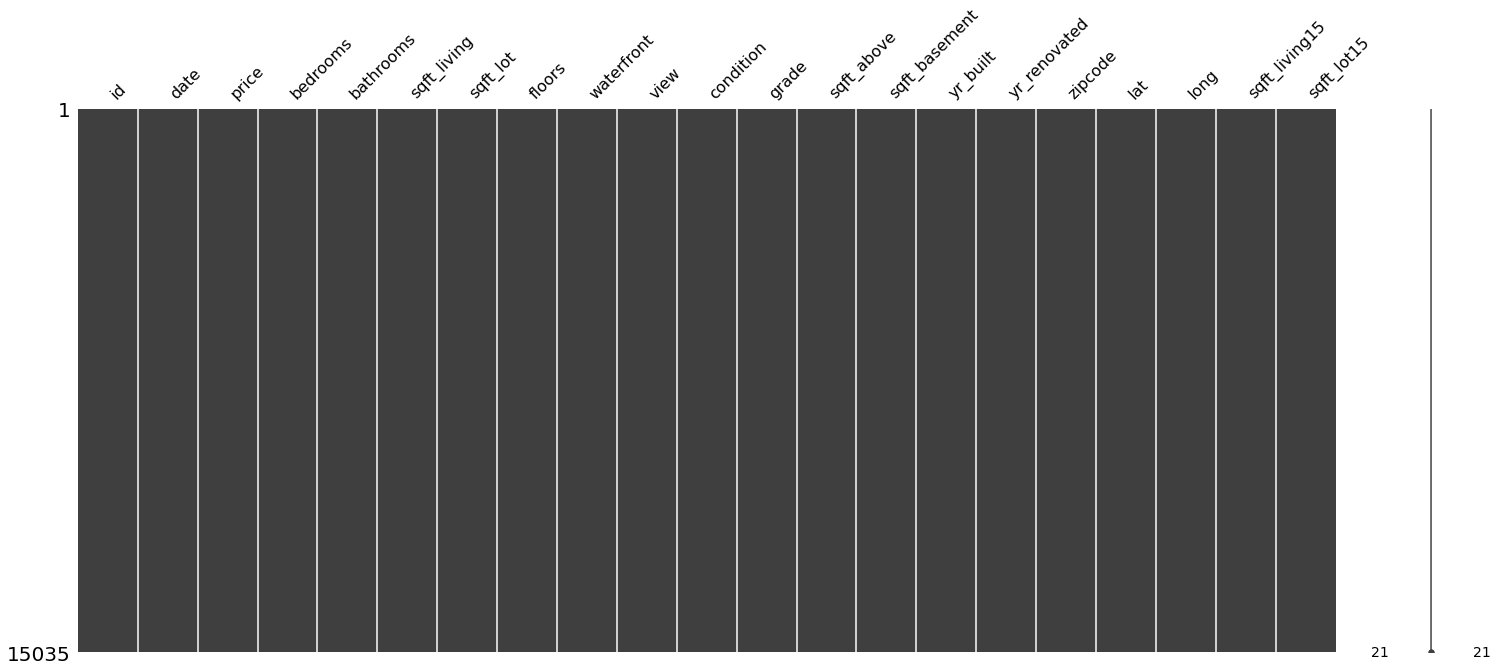

In [13]:
msno.matrix(train)

In [14]:
#중복된 데이터 확인

train.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
15030    False
15031    False
15032    False
15033    False
15034    False
Length: 15035, dtype: bool

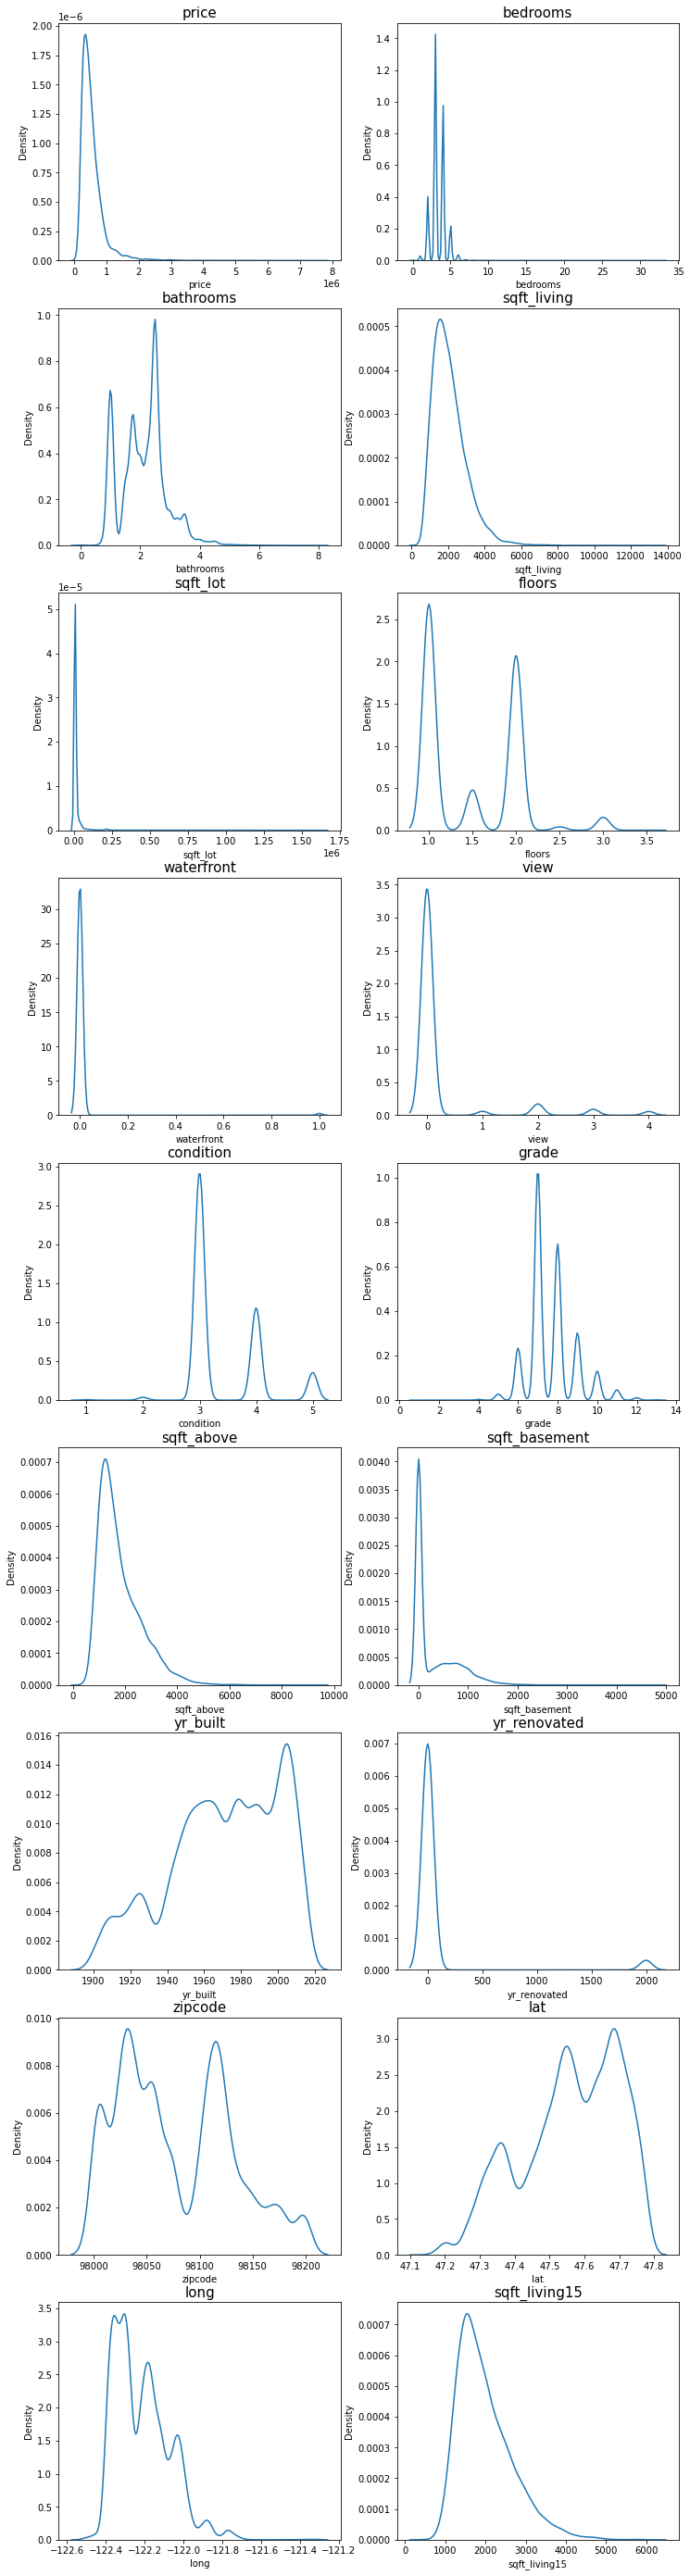

In [15]:
#feature 시각화
#id 변수 제외

fig, ax = plt.subplots(9, 2, figsize=(12, 50))   

count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [16]:
#타겟변수 확인
y = train['price']
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [17]:
#타겟변수 data 확인 
y.describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

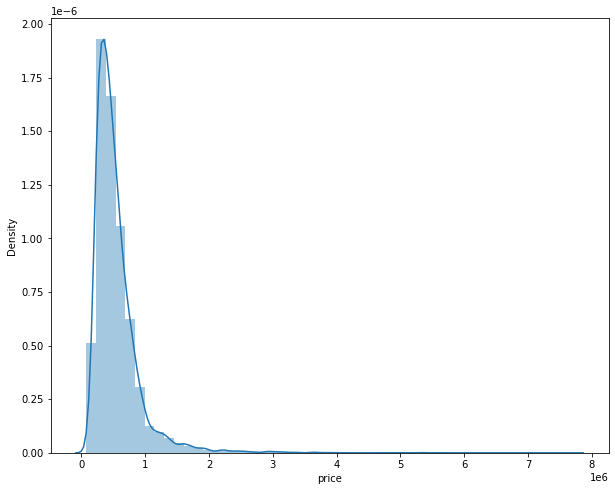

In [18]:
#타겟변수 시각화
f, ax = plt.subplots(figsize=(10,8))
sns.distplot(y)

In [19]:
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

Skewness: 4.290252
Kurtosis: 40.154919


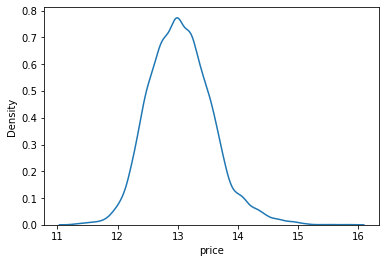

In [20]:
y_log_transformation = np.log1p(y)
sns.kdeplot(y_log_transformation)
plt.show()

아래 로그 변환 비교부분은 아래 커널 코드 참조해서 작성 


https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12

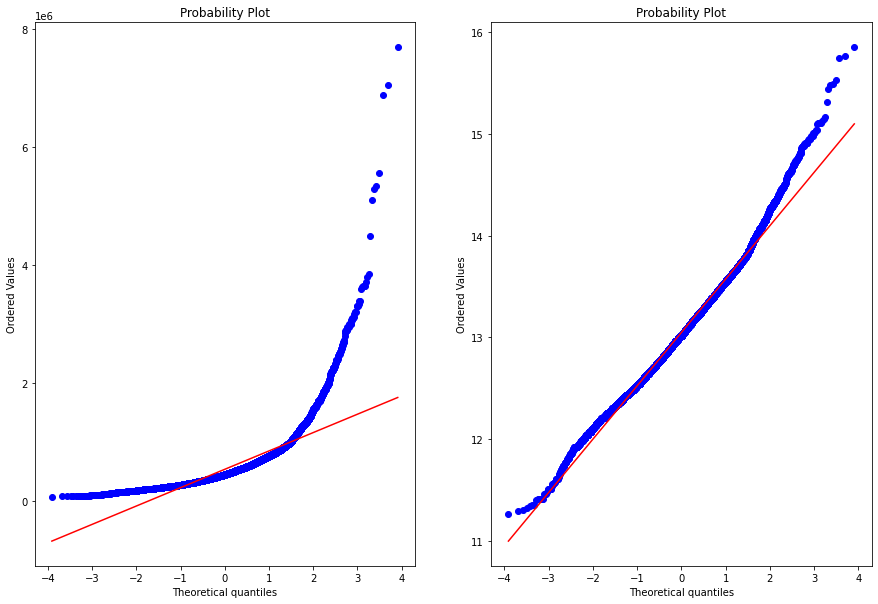

In [21]:
#시각화를 통해 정규화되었음을 확인

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(y, plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log(y), plot=plt)

In [22]:
y = np.log1p(y)

In [23]:
#다른 feature들 역시 왜도가 높음을 확인, 따라서 skew_columns 지정 후 해당 데이터들 log 변환!
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)


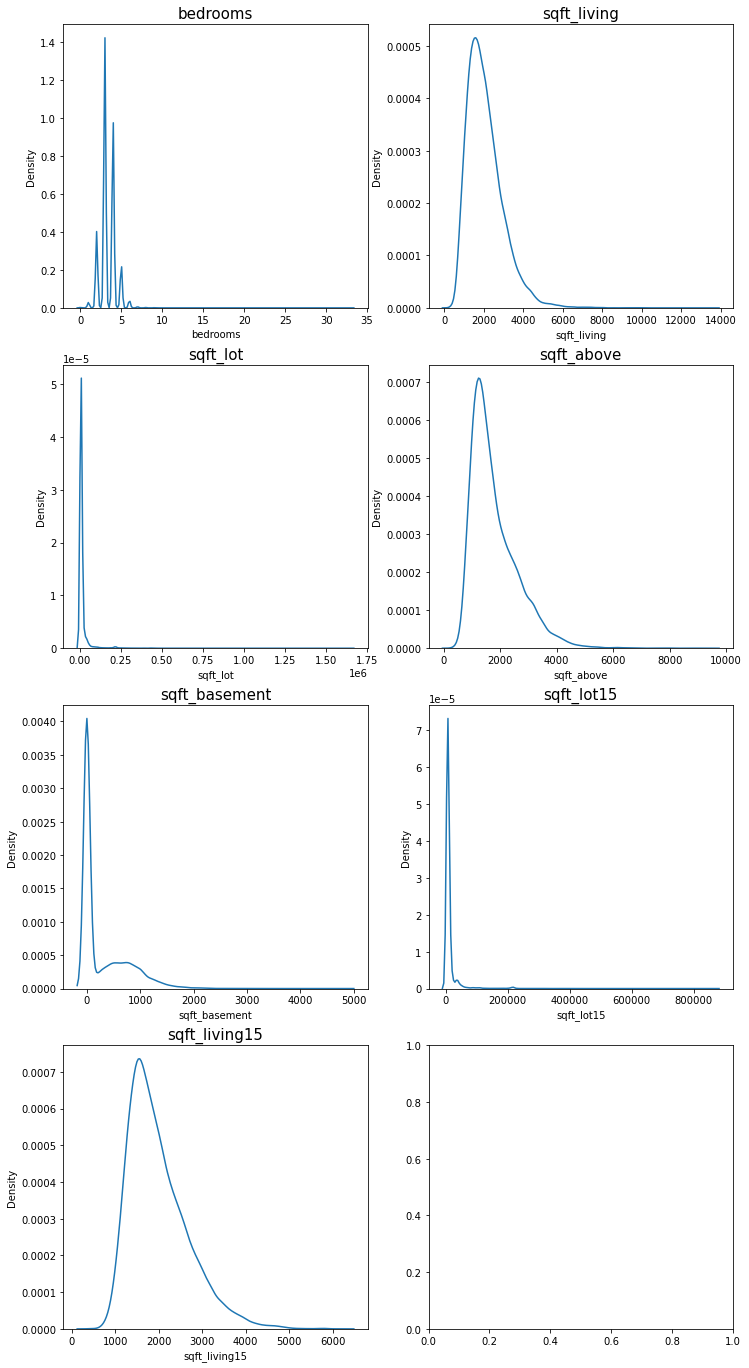

In [24]:
#Log스케일 변환해준 skew_columns 시각화

fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

스피어만 상관관계를 사용하였습니다. 스피어만 순위 상관관계는 범주형 변수가 포함되었을 때 두 변인의 상관관계를 파악하기 위해  사용되는 ‘비모수적 척도’이다. ‘비모수적’이란 모집단의 특정분포를 가정하지 않고 접근하는 방식을 의미하며, 정규분포 조건에 충족하지 못하면 비모수적 상관계수로 풀어나갈 수 있다. 스피어만 상관계수는 값에 순위를 매겨 그 순위에 대한 상관계수를 구하는 특성을 갖는다. 해당 데이터에서는 ‘Grade’라는 feature가 존재하무로 연속형 변수에 사용되는 피어슨 상관관계가 아닌 스피어만 상관관계를 통하여  해당 데이터셋의 상관관계를 히트맵으로 시각화하였다.

아래 커널 코드에서 가져옴.

https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


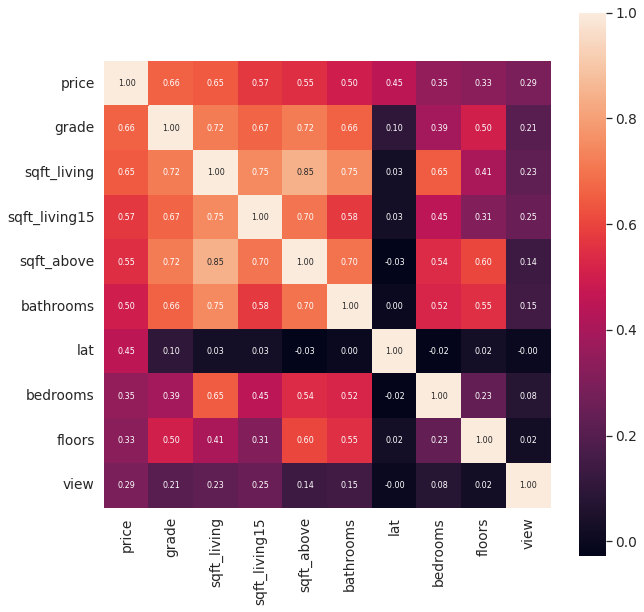

In [25]:
cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = sp.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

다음으로 데이터 변수를 수정해주어야한다. Sqft_ratio, is_basement, is_renovated, yr_renovated 변수를 지정하고, zipcode의 경우 price와 grouping하여 zipcode_num으로 재구성한다. 

부지 면적 대비 실제 사용 면적 비율,15개의 부지 면적 대비 실제 사용 면적 평균 비율
을 통해 ratio 변수를 추가하고, is_basement, is_renovated를 통해
지하실, 재건축 변수를 binary변수로 바꾸어준다.

아래의 코드는 이 커널을 참조.

https://www.kaggle.com/code/casim0/house-price-ml/notebook

https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12/notebook


In [26]:
train_test_data = [train, test]

for data in train_test_data:

    # 부지 면적 대비 실제 사용 면적 비율
    data['sqft_ratio'] = data['sqft_living'] / data['sqft_lot']
        
    # 15개의 부지 면적 대비 실제 사용 면적 평균 비율
    data['sqft_ratio15'] = data['sqft_living15'] / data['sqft_lot15'] 
    
    #지하실 유무
    data['is_basement'] = data['sqft_basement'].map(lambda x: 1 if x != 0 else 0)
    
    #재건축 여부
    data['is_renovated'] = data['yr_renovated'].apply(lambda x: 0 if x == 0 else 1)

    data['total_rooms'] = data['bedrooms'] + data['bathrooms']
    
    # 거실의 비율 
    data['sqft_ratio'] = data['sqft_living'] / data['sqft_lot']
    
    data['sqft_total_size'] = data['sqft_above'] + data['sqft_basement']
    
    # 면적 대비 거실의 비율 
    data['sqft_ratio_1'] = data['sqft_living'] / data['sqft_total_size']
    
    data['sqft_ratio15'] = data['sqft_living15'] / data['sqft_lot15'] 

In [27]:
train.head()

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0  1.386294       1.00     7.074117  8.639588     1.0   
1   1  201502  180000.0  1.098612       1.00     6.647688  9.210440     1.0   
2   2  201502  510000.0  1.386294       2.00     7.427144  8.997271     1.0   
3   3  201406  257500.0  1.386294       2.25     7.447751  8.827615     2.0   
4   4  201501  291850.0  1.386294       1.50     6.966967  9.181118     1.0   

   waterfront  view  ...     long  sqft_living15  sqft_lot15  sqft_ratio  \
0           0     0  ... -122.257       7.201171    8.639588    0.818803   
1           0     0  ... -122.233       7.908755    8.995041    0.721756   
2           0     0  ... -122.045       7.496097    8.923191    0.825489   
3           0     0  ... -122.327       7.713785    8.827615    0.843688   
4           0     0  ... -122.315       7.409136    9.181118    0.758837   

   sqft_ratio15  is_basement  is_renovated  total_rooms  sqft_total_size  \
0      0.833509            0             0     2.386294         7.074117   
1      0.879235            0             0     2.098612         6.647688   
2      0.840069            0             0     3.386294         7.427144   
3      0.873824            0             0     3.636294         7.447751   
4      0.806997            0             0     2.886294         6.966967   

   sqft_ratio_1  
0           1.0  
1           1.0  
2           1.0  
3           1.0  
4           1.0  

[5 rows x 28 columns]

In [28]:
#zipcode 수정
#zipcode를 price와 함께  묶어주는 이유는 예컨대 비슷한 zipcode를 가지고있다는 것은 ‘근처’의 동네라는 뜻이고,
#대게의 경우 동네의 집값은 서로 비슷하기 마련이다. 따라서 zipcode를 통해 집값 예측에 주요한 변수로 사용할 수 있게끔 바꾸어준다.

train_zipcode = train[['zipcode','price']].groupby('zipcode', as_index = False).mean().sort_values('price')
train_zipcode.head()

zipcode          price
1     98002  235664.526718
64    98168  236837.172973
20    98032  255418.411765
0     98001  272469.577406
13    98023  282004.647564

In [29]:
zipcode_num = {}
for i in range(0, 70):
    zipcode = train_zipcode['zipcode'].iloc[i]
    zipcode_num[zipcode] = i
    
zipcode_num

{98002: 0,
 98168: 1,
 98032: 2,
 98001: 3,
 98023: 4,
 98148: 5,
 98003: 6,
 98188: 7,
 98031: 8,
 98030: 9,
 98198: 10,
 98055: 11,
 98178: 12,
 98042: 13,
 98106: 14,
 98022: 15,
 98092: 16,
 98058: 17,
 98146: 18,
 98108: 19,
 98038: 20,
 98133: 21,
 98155: 22,
 98118: 23,
 98126: 24,
 98056: 25,
 98019: 26,
 98010: 27,
 98045: 28,
 98166: 29,
 98028: 30,
 98125: 31,
 98014: 32,
 98011: 33,
 98070: 34,
 98059: 35,
 98034: 36,
 98065: 37,
 98136: 38,
 98117: 39,
 98072: 40,
 98103: 41,
 98107: 42,
 98024: 43,
 98116: 44,
 98029: 45,
 98115: 46,
 98144: 47,
 98027: 48,
 98122: 49,
 98008: 50,
 98007: 51,
 98052: 52,
 98177: 53,
 98053: 54,
 98077: 55,
 98074: 56,
 98075: 57,
 98005: 58,
 98033: 59,
 98199: 60,
 98006: 61,
 98119: 62,
 98105: 63,
 98109: 64,
 98102: 65,
 98112: 66,
 98040: 67,
 98004: 68,
 98039: 69}

In [30]:
train_test_data = [train, test]
for dataset in train_test_data:
    train['zipcode_num'] = train['zipcode'].map(zipcode_num)
    test['zipcode_num'] = test['zipcode'].map(zipcode_num)

In [31]:
train.head()

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0  1.386294       1.00     7.074117  8.639588     1.0   
1   1  201502  180000.0  1.098612       1.00     6.647688  9.210440     1.0   
2   2  201502  510000.0  1.386294       2.00     7.427144  8.997271     1.0   
3   3  201406  257500.0  1.386294       2.25     7.447751  8.827615     2.0   
4   4  201501  291850.0  1.386294       1.50     6.966967  9.181118     1.0   

   waterfront  view  ...  sqft_living15  sqft_lot15  sqft_ratio  sqft_ratio15  \
0           0     0  ...       7.201171    8.639588    0.818803      0.833509   
1           0     0  ...       7.908755    8.995041    0.721756      0.879235   
2           0     0  ...       7.496097    8.923191    0.825489      0.840069   
3           0     0  ...       7.713785    8.827615    0.843688      0.873824   
4           0     0  ...       7.409136    9.181118    0.758837      0.806997   

   is_basement  is_renovated  total_rooms  sqft_total_size  sqft_ratio_1  \
0            0             0     2.386294         7.074117           1.0   
1            0             0     2.098612         6.647688           1.0   
2            0             0     3.386294         7.427144           1.0   
3            0             0     3.636294         7.447751           1.0   
4            0             0     2.886294         6.966967           1.0   

   zipcode_num  
0           12  
1           30  
2           56  
3            6  
4           10  

[5 rows x 29 columns]

이상치 제거..

 다음과 같은 절차로 이상치 제거를 시도하였으나, 어떤 이유에서인지.. 아래와 같이 처리하면 Grid search가 안되는 오류가 발생한다. 이걸로 시간을 허비하다가.. 우선적으로 제출 후 어떤 문제가 있었는지 살펴볼 필요가 있다. 

In [32]:
#sqft_living 
#먼저 sqft_living과 price의 상관관계에 관해 조금 더 들여다보자! #sqft_living은 주거 공간의 평방 피트(면적)을 나타낸다. 
#집값에 영향을 미치는 요인에서 가장 첫번째로 생각해볼만 한 것은 "평수가 넓을 수록 집값이 비싸지 않을까?"이니까! 요 변수에서 어떤 outlier들이 있는지 살펴보자.

'''sqft_price = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.regplot(x='sqft_living', y="price", data=data)'''

'sqft_price = pd.concat([train[\'price\'], train[\'sqft_living\']], axis=1)\nf, ax = plt.subplots(figsize=(12, 8))\nfig = sns.regplot(x=\'sqft_living\', y="price", data=data)'

In [33]:
'''train.loc[train['sqft_living'] > 12000]'''

"train.loc[train['sqft_living'] > 12000]"

In [34]:
#시각화 결과에 따라 sqft_living이 12000 이상인 값은 outlier라 판단할 수 있다. 따라 이를 제거해주자!
'''train = train.loc[train['sqft_living'] < 12000]'''

"train = train.loc[train['sqft_living'] < 12000]"

In [35]:
'''#price에서도 제거!
del y[5108]
del y[8912]'''

'#price에서도 제거!\ndel y[5108]\ndel y[8912]'

In [36]:
drop_columns = ['id']
train = train.drop(drop_columns, axis = 1)
test = test.drop(drop_columns, axis = 1)
train.head()

date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  201410  221900.0  1.386294       1.00     7.074117  8.639588     1.0   
1  201502  180000.0  1.098612       1.00     6.647688  9.210440     1.0   
2  201502  510000.0  1.386294       2.00     7.427144  8.997271     1.0   
3  201406  257500.0  1.386294       2.25     7.447751  8.827615     2.0   
4  201501  291850.0  1.386294       1.50     6.966967  9.181118     1.0   

   waterfront  view  condition  ...  sqft_living15  sqft_lot15  sqft_ratio  \
0           0     0          3  ...       7.201171    8.639588    0.818803   
1           0     0          3  ...       7.908755    8.995041    0.721756   
2           0     0          3  ...       7.496097    8.923191    0.825489   
3           0     0          3  ...       7.713785    8.827615    0.843688   
4           0     0          3  ...       7.409136    9.181118    0.758837   

   sqft_ratio15  is_basement  is_renovated  total_rooms  sqft_total_size  \
0      0.833509            0             0     2.386294         7.074117   
1      0.879235            0             0     2.098612         6.647688   
2      0.840069            0             0     3.386294         7.427144   
3      0.873824            0             0     3.636294         7.447751   
4      0.806997            0             0     2.886294         6.966967   

   sqft_ratio_1  zipcode_num  
0           1.0           12  
1           1.0           30  
2           1.0           56  
3           1.0            6  
4           1.0           10  

[5 rows x 28 columns]

In [37]:
del train['price']

In [38]:
#모델링 준비

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

random_state=2020   

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [40]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 118014.88166072128,
 'XGBRegressor': 114800.58959480151,
 'LGBMRegressor': 108543.7379852559,
 'RandomForestRegressor': 124910.49268648651}

In [41]:
#각 모델별 RMSE를 구하기 위해 get_score 함수 생성
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [42]:
get_scores(models, train, y)

RMSE
RandomForestRegressor      124910.492686
GradientBoostingRegressor  118014.881661
XGBRegressor               114800.589595
LGBMRegressor              108543.737985

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
#GridSeach 함수지정

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

아래에서 하이퍼파라미터를 grid search! 

In [46]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [-1],
    'learning_rate': [0.005],
    'num_iteration': [5000],
    'num_leaves': [30],
    'min_data_in_leaf': [20],
    'feature_fraction': [0.8],
    'boosting': ['gbdt'],
    'objective':['regression'],
    'num_boost_round':[4500,5000],
    'metric':['rmse']
}

model = LGBMRegressor(random_state=random_state)

my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argum

[LightGBM] [Warning] num_iterations is set with num_boost_round=4500, will be overridden by num_iteration=5000. Current value: num_iterations=5000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=4500, num_iteration=5000 will be ignored. Current value: num_iterations=4500
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] num_iterations is set with num_boost_round=4500, will be overridden by num_iteration=5000. Current value: num_iterations=5000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=50, num_boost_round=4500, num_iteration=5000, num_leaves=30, objective=regression; total time=  16.4s
[LightGBM] [Warning] num_iterations is set with num_boost_round=5000, will be overridden by num_iteration=5000. Current value: num_iterations=5000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=5000, num_iteration=5000 will be ignored. Current value: num_iterations=5000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=50, num_boost_round=4

/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argum

[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=50, num_boost_round=4500, num_iteration=5000, num_leaves=30, objective=regression; total time=  17.5s
[LightGBM] [Warning] num_iterations is set with num_boost_round=5000, will be overridden by num_iteration=5000. Current value: num_iterations=5000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=5000, num_iteration=5000 will be ignored. Current value: num_iterations=5000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=50, num_boost_round=4500, num_iteration=5000, num_leaves=30, objective=regression; total time=  18.8s
[LightGBM] [Warning] num_iterations is set with num_boost_round=5000, will be overridden by num_iteration=5000. Current value: num_iterations=5000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=5000, num_iteration=5000 will be ignored. Current value: num_iterations=5000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=50, num_boost_round=5000, num_iteration=5000, num_leaves=30, objective=regression; total time=  16.4s
[LightGBM] [Warning] num_iterations is set with num_boost_round=4500, will be overridden by num_iteration=5000. Current value: num_iterations=5000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=4500, num_iteration=5000 will be ignored. Current value: num_iterations=4500
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=50, num_boost_round=5000, num_iteration=5000, num_leaves=30, objective=regression; total time=  18.6s
[LightGBM] [Warning] num_iterations is set with num_boost_round=4500, will be overridden by num_iteration=5000. Current value: num_iterations=5000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=4500, num_iteration=5000 will be ignored. Current value: num_iterations=4500
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=50, num_boost_round=5000, num_iteration=5000, num_leaves=30, objective=regression; total time=  20.5s
[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=50, num_boost_round=5000, num_iteration=5000, num_leaves=30, objective=regression; total time=  20.4s
[LightGBM] [Warning] num_iterations is set with num_boost_round=4500, will be overridden by num_iteration=5000. Current value: num_iterations=5000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=4500, num_iteration=5000 will be ignored. Current value: num_iterations=4500
[LightGBM] [Warning] min_data_in_leaf is 

/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argum

[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=50, num_boost_round=5000, num_iteration=5000, num_leaves=30, objective=regression; total time=  18.6s
[LightGBM] [Warning] num_iterations is set with num_boost_round=4500, will be overridden by num_iteration=5000. Current value: num_iterations=5000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=5000, num_iteration=5000 will be ignored. Current value: num_iterations=5000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=100, num_boost_round=4500, num_iteration=5000, num_leaves=30, objective=regression; total time=  15.2s
[LightGBM] [Warning] num_iterations is set with num_boost_round=5000, will be overridden by num_iteration=5000. Current value: num_iterations=5000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=5000, num_iteration=5000 will be ignored. Current value: num_iterations=5000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=100, num_boost_round=4500, num_iteration=5000, num_leaves=30, objective=regression; total time=  15.1s
[LightGBM] [Warning] num_iterations is set with num_boost_round=5000, will be overridden by num_iteration=5000. Current value: num_iterations=5000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=5000, num_iteration=5000 will be ignored. Current value: num_iterations=5000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=100, num_boost_round=4500, num_iteration=5000, num_leaves=30, objective=regression; total time=  16.9s
[LightGBM] [Warning] num_iterations is set with num_boost_round=5000, will be overridden by num_iteration=5000. Current value: num_iterations=5000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=5000, num_iteration=5000 will be ignored. Current value: num_iterations=5000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=100, num_boost_round=4500, num_iteration=5000, num_leaves=30, objective=regression; total time=  18.1s
[LightGBM] [Warning] num_iterations is set with num_boost_round=5000, will be overridden by num_iteration=5000. Current value: num_iterations=5000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=5000, num_iteration=5000 will be ignored. Current value: num_iterations=5000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=100, num_boost_round

/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argum

[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=100, num_boost_round=5000, num_iteration=5000, num_leaves=30, objective=regression; total time=  17.2s
[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=100, num_boost_round=5000, num_iteration=5000, num_leaves=30, objective=regression; total time=  16.7s
[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=100, num_boost_round=5000, num_iteration=5000, num_leaves=30, objective=regression; total time=  14.4s
[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth=-1, metric=rmse, min_data_in_leaf=20, n_estimators=100, num_boost_round=5000, num_iteration=5000, num_leaves=30, objective=regression; total time=  16.4s
[CV] END boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_depth

/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kimddogyun/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set with num_boost_round=5000, will be overridden by num_iteration=5000. Current value: num_iterations=5000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=5000, num_iteration=5000 will be ignored. Current value: num_iterations=5000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


boosting  feature_fraction  learning_rate  max_depth metric  \
1     gbdt               0.8          0.005         -1   rmse   
3     gbdt               0.8          0.005         -1   rmse   
0     gbdt               0.8          0.005         -1   rmse   
2     gbdt               0.8          0.005         -1   rmse   

   min_data_in_leaf  n_estimators  num_boost_round  num_iteration  num_leaves  \
1                20            50             5000           5000          30   
3                20           100             5000           5000          30   
0                20            50             4500           5000          30   
2                20           100             4500           5000          30   

    objective     score     RMSLE  
1  regression -0.025206  0.158763  
3  regression -0.025206  0.158763  
0  regression -0.025215  0.158792  
2  regression -0.025225  0.158825

RSMLE가 0.1594로 낮아진 것을 확인!

In [47]:
'''param_grid = {
    'n_estimators': 50,
    'max_depth': -1,
    'learning_rate': 0.005,
    'num_iteration': 5000,
    'num_leaves': 30,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'boosting': 'gbdt',
    'objective':'regression',
    'num_boost_round':4500,
    'metric':'rmse'
}'''

model_lgbm = LGBMRegressor(
    n_estimators=50,
    max_depth=-1,
    learning_rate=0.5,
    num_iteration=5000,
    num_leaves=20,
    feature_fraction=0.8,
    min_data_in_leaf=20,
    boosting='gbdt',
    objective='regression',
    num_boost_round=5000,
    metric='rmse',
    random_state=random_state)

In [49]:
#model 학습과 submission file 생성을 한꺼번에 하기 위한 save_submission 함수 선언

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = 'house_data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))


In [52]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.1587')

house_data/submission_lgbm_RMSLE_0.1587.csv saved!


submission_lgbm_RMSLE_0.1587.csv

Score: 115035.52175
Public score: 119153.38311


## 짧은회고


1. 전처리과정을 충분히거치지 않은 상태에서 하이퍼파라미터 튜닝에 골몰하는 것은 그닥 유익한 선택이 아니다.

2. 시각화에 골몰하는 것 역시 사실 모델의 ‘학습’이 아니라 내 ‘학습’에 그닥 도움이 안될 가능성이 높다.

3. 특히 어떤 변수들을 결합하고, categorical 변수들을 어떻게 처리할지에 대한 문제는 남의 커널을 보지않고, 도저히 답이 안떠오르는 문제이다.

4. 하이퍼파라미터 튜닝에 있어서 어떠한 구간들을 search할 것인가?에 대한 문제 역시 아직 막연하다. 어떠한 구간이 좋은 구간인지 모른 상태로 무작정 넓은 구간들을 탐색하는 작업은 마찬가지로 나한테나.. 모델한테나…  도움’이 안된다. 

5. 이상치를 제거를 하고나서 Grid search가 동작하지 않는 오류로 고생했다. 일단 이상치를 놔둔 상태로 accuracy를 높인는 다른 방안들을 더 찾아보는 것을 선택했는데, 이상치 제거만 두고 따로 학습할 필요가 있다.

6. 아직 Heatmap을 해당 코드의 ‘미적’ 목표로서만 사용하는 것 같다. 상관관계로부터 어떤 인사이트를 얻고, 변수를 어떻게 전처리하면 될 것인지에 대한 인사이트를 충분히 획득하지 못한 채 ‘그냥’ 지나간다. 상관관계에 관한 통계적 지식을 쌓는것부터 시작해야만 한다.

7. lightbm 개념에 대해서 익숙하지 않은 채 Grid search 돌리는 것은 의미가 없다. 근데 사실 개념이란 것도 잘 모르겠다.. 개념을 안다고 해당 데이터셋에 어떠한 하이퍼파라미터를 넣어야하는지 곧바로 연결되지 않는다. 근데 할 수 있는 것은 개념을 다시보는 방법밖에 없는듯하다..

8. 다음에 다시 재도전하겠다.. 나중에 보자 하우쓰 프라이스...
